# Human Resource Analytics
#### Andrew Orso
Why are our best and most experienced employees leaving prematurely? Have fun with this database and try to predict which valuable employees will leave next. Fields in the dataset include:

    Satisfaction Level
    Last evaluation
    Number of projects
    Average monthly hours
    Time spent at the company
    Whether they have had a work accident
    Whether they have had a promotion in the last 5 years
    Departments (column sales)
    Salary
    Whether the employee has left


In [3]:
%load_ext rpy2.ipython
%qtconsole

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import warnings
import math

print(os.getcwd())

/home/aorso/Documents/github/kaggle_hr_analytics


In [4]:
hr_data = pd.read_csv('HR_comma_sep.csv')

# EDA

In [7]:
%%R

library(dplyr)
library(ggplot2)
library(tibble)
library(gridExtra)
library(grid)

## Shamelessly stolen from the R cookbook
## http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [15]:
print(hr_data.shape)
hr_data

(14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


This is an extremely clean dataset. There are no NAs to worry about, though if there were it could be taken care of with some type of imputation (probably column dependent, e.g., NA on number_project might mean zero where as NA on satisfaction, it may make more sense to use the mean) on the numerics, and a new "unknown" level for the categoricals.

Beyond that, the rate of attrition appears to be 24%. So not low enough that we might need to worry about any kind of sampling. 

In [8]:
%%R -i hr_data

print(paste0('Any NAs?: ', any(is.na(hr_data))))
print(paste0('Occurrence Rate: ', mean(hr_data$left)))


# A tibble: 6 x 10
  satisfaction_level last_evaluation number_project average_montly_hours
               <dbl>           <dbl>          <int>                <int>
1               0.38            0.53              2                  157
2               0.80            0.86              5                  262
3               0.11            0.88              7                  272
4               0.72            0.87              5                  223
5               0.37            0.52              2                  159
6               0.41            0.50              2                  153
# ... with 6 more variables: time_spend_company <int>, Work_accident <int>,
#   left <int>, promotion_last_5years <int>, sales <fctr>, salary <fctr>
[1] "Any NAs?: FALSE"
[1] "Occurrence Rate: 0.238082538835922"


Just want to be safe and make sure the data looks reasonable here and there are no things out of place.

In [23]:
%%R -i hr_data
sapply(hr_data, table)

$satisfaction_level

0.09  0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19  0.2 0.21 0.22 0.23 0.24 
 195  358  335   30   54   73   76   79   72   63   74   69   67   60   54   80 
0.25 0.26 0.27 0.28 0.29  0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39  0.4 
  34   30   30   31   38   39   59   50   36   48   37  139  241  189  175  209 
0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49  0.5 0.51 0.52 0.53 0.54 0.55 0.56 
 171  155  224  211  203   95   42  149  209  229  187  196  179  185  179  187 
0.57 0.58 0.59  0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69  0.7 0.71 0.72 
 210  182  219  193  208  188  209  187  199  228  177  162  209  205  171  230 
0.73 0.74 0.75 0.76 0.77 0.78 0.79  0.8 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 
 246  257  226  234  252  241  217  222  220  241  234  247  207  200  225  187 
0.89  0.9 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99    1 
 237  220  224  198  169  167  181  203  176  183  172  111 

$last_evaluation

0.36 0.37 0.38 0.39  0.4 0.4

Plot histograms of all of the features we have to get a feel for the data and try to identify any possible outliers. That said it doesn't appear that there are any outliers.

/home/aorso/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


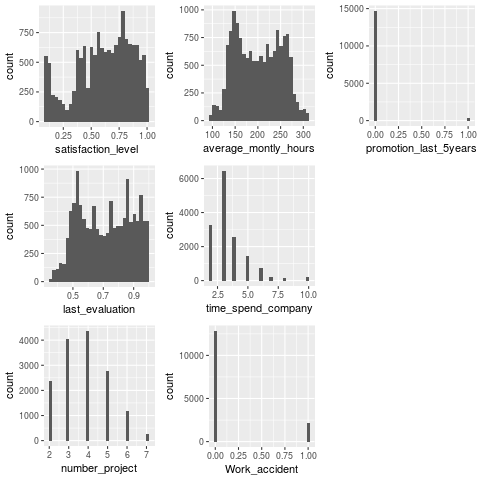

In [11]:
%%R -i hr_data

plots <- list()  
for (i in setdiff(names(hr_data), c('left','sales', 'salary'))) {
    p1 = ggplot(data = hr_data, aes_string(x = i)) + geom_histogram()
    plots[[i]] <- p1  # add each plot into plot list
}
multiplot(plotlist = plots, cols = 3)

Now we want to try and see if there are any obvious relationships between the various features and our dependent variable 'left'.

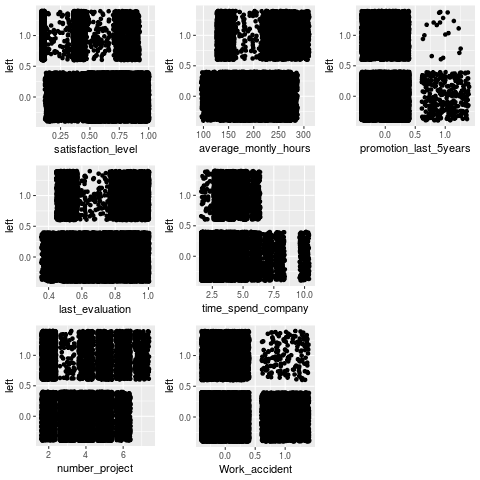

In [18]:
%%R -i hr_data

plots <- list()  
for (i in setdiff(names(hr_data), c('left','sales', 'salary'))) {
    p1 = ggplot(data = hr_data, aes_string(x = i, y = 'left')) + geom_jitter()
    plots[[i]] <- p1  # add each plot into plot list
}
multiplot(plotlist = plots, cols = 3)

For our categorical variables, let's try and see if there is any sepearation for our dependent variable relative to the naive solution of 23.8% leaving. We definitely see some separation with salary and even with the position, there are a few smaller groups that perform differently than the expectation.

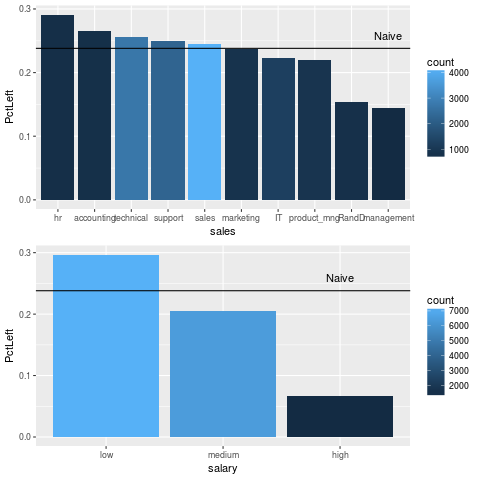

In [19]:
%%R -i hr_data

a = hr_data %>% 
    group_by(sales) %>% 
    summarize(PctLeft = mean(left), count = n()) %>% 
    arrange(-PctLeft) %>%
    mutate(sales = factor(sales, levels = sales)) %>%
    ggplot(aes(x = sales, y = PctLeft, fill = count)) + 
        geom_bar(stat = 'identity') + 
        geom_hline(yintercept = mean(hr_data$left)) +
        annotate("text", 10, mean(hr_data$left) + 0.02, label = "Naive") 


b = hr_data %>% 
    group_by(salary) %>% 
    summarize(PctLeft = mean(left), count = n()) %>% 
    arrange(-PctLeft) %>% 
    mutate(salary = factor(salary, levels = salary)) %>%
    ggplot(aes(x = salary, y = PctLeft, fill = count)) + 
        geom_bar(stat = 'identity') + 
        geom_hline(yintercept = mean(hr_data$left)) +
        annotate("text", 3, mean(hr_data$left) + 0.02, label = "Naive") 


multiplot(a,b,cols=1)

Another way of examining the numeric variables is to decile them and see if there are any buckets that perform considerably different. Some unexpected results show up in a few variables where we see high attrition at lower levels and then much lower attrition in the middle before it returns to high levels.


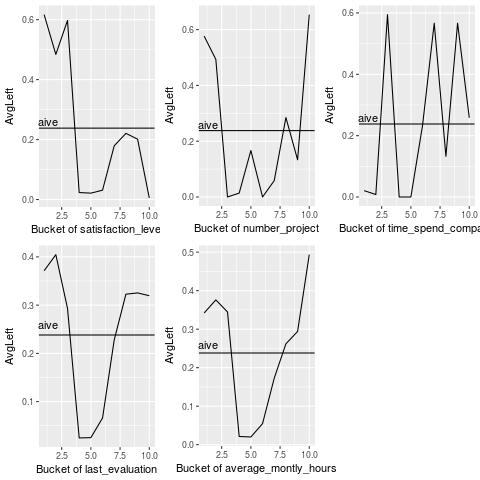

In [27]:
%%R -i hr_data

hr_data_bkt = hr_data %>% 
    mutate(left = as.character(left)) %>%
    mutate_if(is.numeric, funs(ntile(.,n=10))) %>%
    mutate(left = as.numeric(left))

plots <- list()  
for (i in setdiff(names(hr_data), c('left','sales', 'salary', 'promotion_last_5years', 'Work_accident'))) {
    p1 = hr_data_bkt %>% 
        group_by_(.dots=list(i)) %>% 
        summarize(AvgLeft = mean(left)) %>%
        ggplot(aes_string(x = i, y = 'AvgLeft')) + 
            geom_line() + 
            geom_hline(yintercept = mean(hr_data$left)) + 
            annotate("text", 1, mean(hr_data$left) + 0.02, label = "Naive") + 
            xlab(paste0("Bucket of ", i))
    plots[[i]] <- p1  # add each plot into plot list
}
multiplot(plotlist = plots, cols = 3)



# Modeling
## Try to predict which employees are going to leave with a naive baseline of 23.8%

We will start with logistic regression to get a good baseline as this is an easy model to get going. 

For the purposes of this exercise, we will measure the error using logloss as this is a very appropriate measure for 0/1 classification. Essentially, given a probability, log loss penalizes heavily for being far away from the wrong answer (e.g., 0.1 when it's truly a 1) but contributes little when the probabily is very close. We are penalizing classifiers that are confident about a wrong classification.

For the purposes of this exercise, we will measure the error using accuracy as this most closely reflects the business case we are replicating. We would probably want to bias the error measurement towards getting those who attrite correct, rather than general accuracy, but for this exercise we will just use accuracy.

In [60]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Our data has both categoricals and numerics but sklearn expects things to be only numerics so we are going to dummy out our categorical variables. 

In [46]:
hr_data_dummy = pd.get_dummies(hr_data)

In [47]:
X = hr_data_dummy.drop('left', axis = 1)
y = hr_data_dummy['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [41]:
print(y_train.mean())
print(y_test.mean())

0.23876989749145763
0.23533333333333334


## Logistic Regression

In [49]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.789399116593
0.783333333333


82% of employees we predicted wouldn't leave, didn't leave and 57% of employees we predicted would leave, did leave. That said, we only identified 33% of those people who did actually leave. Our overall accuracy was 78.33, repeating of course, percent.

In [74]:
print(confusion_matrix(y_test, lr.predict(X_test))) # known x predicted
print(accuracy_score(y_test, lr.predict(X_test)))
print(classification_report(y_test, lr.predict(X_test)))

[[2118  176]
 [ 474  232]]
0.783333333333
             precision    recall  f1-score   support

          0       0.82      0.92      0.87      2294
          1       0.57      0.33      0.42       706

avg / total       0.76      0.78      0.76      3000



In [75]:
eval_df = pd.DataFrame(
    {
     'Predictions': lr.predict(X_test),
     'Actuals': y_test
    }
)

In [171]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(lr.coef_[0],3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print(importances)

                       importance
feature                          
salary_low                  0.699
last_evaluation             0.654
sales_hr                    0.322
time_spend_company          0.266
salary_medium               0.194
sales_technical             0.146
sales_marketing             0.090
sales_support               0.080
sales_accounting            0.055
sales_sales                 0.026
average_montly_hours        0.005
sales_product_mng          -0.014
sales_IT                   -0.095
number_project             -0.307
sales_management           -0.386
sales_RandD                -0.609
promotion_last_5years      -1.155
salary_high                -1.276
Work_accident              -1.514
satisfaction_level         -4.121


## Random Forest
Now let's try something a little more powerful. We will try a random forest to see if we can get better results. 

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [158]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [159]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

1.0
0.987333333333


In [87]:
print(confusion_matrix(y_test, rf.predict(X_test))) # known x predicted
print(accuracy_score(y_test, rf.predict(X_test)))
print(classification_report(y_test, rf.predict(X_test)))

[[2286    8]
 [  26  680]]
0.988666666667
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2294
          1       0.99      0.96      0.98       706

avg / total       0.99      0.99      0.99      3000



In [92]:
eval_df = pd.DataFrame(
    {
     'Predictions': rf.predict(X_test),
     'Actuals': y_test
    }
)

Let's figure out what features are important so that we can use those to get better at improving retention.

In [160]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print(importances)

                       importance
feature                          
satisfaction_level          0.296
time_spend_company          0.184
number_project              0.178
average_montly_hours        0.167
last_evaluation             0.128
Work_accident               0.010
salary_low                  0.007
salary_high                 0.005
sales_technical             0.004
sales_sales                 0.003
sales_support               0.003
salary_medium               0.003
sales_accounting            0.002
sales_RandD                 0.002
sales_IT                    0.002
promotion_last_5years       0.002
sales_hr                    0.002
sales_marketing             0.001
sales_product_mng           0.001
sales_management            0.001


Before we move on, let's do some parameter tuning to see if we can get a little better.

In [138]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {"max_depth": [3, None],
              "n_estimators": [100,200],
              "max_features": [2,4,10],
              "min_samples_split": [2,5],
              "criterion": ["gini", "entropy"]}
random_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter = 20)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': [3, None], 'n_estimators': [100, 200], 'max_features': [2, 4, 10], 'min_samples_split': [2, 5], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

Doesn't appear that we will do much better than we already were with parameter tuning so let's stay with what we have already. 

In [142]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# XGBoost
We got really good results with the random forest, can we do even better?

In [116]:
from xgboost import XGBClassifier

In [117]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [119]:
print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))

0.976831402617
0.971666666667


In [121]:
print(confusion_matrix(y_test, xgb.predict(X_test))) # known x predicted
print(accuracy_score(y_test, xgb.predict(X_test)))
print(classification_report(y_test, xgb.predict(X_test)))

[[2267   27]
 [  58  648]]
0.971666666667
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      2294
          1       0.96      0.92      0.94       706

avg / total       0.97      0.97      0.97      3000



# Feature Engineering
Can we get any better by creating some additional features?

What did we get wrong with our randomforest?

In [183]:
wrong_vals = X_test.assign(Wrong = np.where(y_test != rf.predict(X_test),1,0))

From this view, it would appear that those people who have spent a lot of time with the company, are likely to stay whether they get a promotion or not. Also though, those who have been with the company for some time but do not get a promotion before 5 or 6 years are much more likely to leave. 

In [179]:
%%R -i hr_data

hr_data %>% group_by(time_spend_company, promotion_last_5years) %>% summarize(AvgLeft = mean(left), count = n())

# A tibble: 16 x 4
# Groups:   time_spend_company [?]
   time_spend_company promotion_last_5years    AvgLeft count
                <int>                 <int>      <dbl> <int>
 1                  2                     0 0.01661442  3190
 2                  2                     1 0.00000000    54
 3                  3                     0 0.24900935  6309
 4                  3                     1 0.11194030   134
 5                  4                     0 0.35170500  2522
 6                  4                     1 0.08571429    35
 7                  5                     0 0.57142857  1456
 8                  5                     1 0.05882353    17
 9                  6                     0 0.29814551   701
10                  6                     1 0.00000000    17
11                  7                     0 0.00000000   152
12                  7                     1 0.00000000    36
13                  8                     0 0.00000000   152
14                  8          

In [220]:
hr_data_dummy = hr_data_dummy.assign(NoPromo4 = np.where(np.logical_and(hr_data_dummy['time_spend_company'] == 4, hr_data_dummy['promotion_last_5years'] == 0),1,0))
hr_data_dummy = hr_data_dummy.assign(NoPromo5 = np.where(np.logical_and(hr_data_dummy['time_spend_company'] == 5, hr_data_dummy['promotion_last_5years'] == 0),1,0))
hr_data_dummy = hr_data_dummy.assign(NoPromo6 = np.where(np.logical_and(hr_data_dummy['time_spend_company'] == 6, hr_data_dummy['promotion_last_5years'] == 0),1,0))

Another possible consideration is maybe there is some relationship between an employees satisfaction level and last evaluation score. Theory here is that maybe if there is a large discrepancy between the two that we actually can find something. 

In [241]:
hr_data_dummy = hr_data_dummy.assign(DiffBetweenEval = abs(hr_data_dummy.satisfaction_level - hr_data_dummy.last_evaluation))

In [242]:
X = hr_data_dummy.drop('left', axis = 1)
y = hr_data_dummy['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [243]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [244]:
print(confusion_matrix(y_test, rf.predict(X_test))) # known x predicted
print(accuracy_score(y_test, rf.predict(X_test)))
print(classification_report(y_test, rf.predict(X_test)))

[[2285    9]
 [  24  682]]
0.989
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2294
          1       0.99      0.97      0.98       706

avg / total       0.99      0.99      0.99      3000

